In [144]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=c39cbbc5031594d1e6a210f836f5666c12d48274b4fb826db82873131853259b
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [170]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
from typing import Optional

import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [34]:
def distribute_nodes_on_circle(n_nodes, radius):
    angles = np.linspace(0, 2*np.pi, n_nodes-1, endpoint=False)  # Divide the circle into equal angles
    x = radius * np.cos(angles)  # Calculate x-coordinates using cosine function
    y = radius * np.sin(angles)  # Calculate y-coordinates using sine function
    positions = np.column_stack((x, y))  # Stack x and y coordinates as column vectors

    positions = np.vstack((positions, np.array([0, 0])))
    return torch.tensor(positions)

In [81]:
# Function to prepare the node features
def get_node_features(nb_nodes: int, image_encoding: torch.Tensor, nb_connections: Optional[int], odometry: Optional[torch.Tensor]):
      """_summary_

      Args:
          nb_nodes (int): total nb of nodes (including the center node), odd number
          image_encoding (torch.Tensor): embeddings of the image
          node_pos_encoding (_type_): circular positional encoding
          nb_connections (Optional[int], optional): nb of connections of each node. Defaults to 2.
          odometry (Optional[torch.Tensor], optional): odom data Defaults to None.
      """
      positions = distribute_nodes_on_circle(n_nodes = nb_nodes, radius=1)

      nb_connections = torch.tensor(nb_connections).unsqueeze(0)
      nb_connections = nb_connections.repeat(nb_nodes-1, 1)
      nb_connections = torch.cat((nb_connections, torch.tensor([nb_nodes-1]).unsqueeze(0)), 0)
      
      image_encoding = image_encoding.repeat(nb_nodes, 1)
      
      feature_vector = torch.concat((image_encoding, nb_connections, positions), 1)
      
      if odometry is not None:
        odometry = odometry.repeat(nb_nodes, 1)
        feature_vector = torch.concat((feature_vector, odometry), 1)  
        
      return feature_vector

# Function to prepare the edge features
def get_edge_features(nb_nodes: int):
  """_summary_

  Args:
      nb_nodes (int): total nb of nodes (including the center node), odd number
  """
  # Define the edge features tensor with shape (2 * nb_nodes + nb_nodes, 1)
  # first 2 * nb_nodes are for the connections between the nodes, should be 1
  # last nb_nodes are for the connections between the new node and the existing nodes, should be -1
  edge_features = torch.ones((2 * (nb_nodes-1) + (nb_nodes-1), 1))
  edge_features[2 * (nb_nodes-1):, :] = -1

  return edge_features

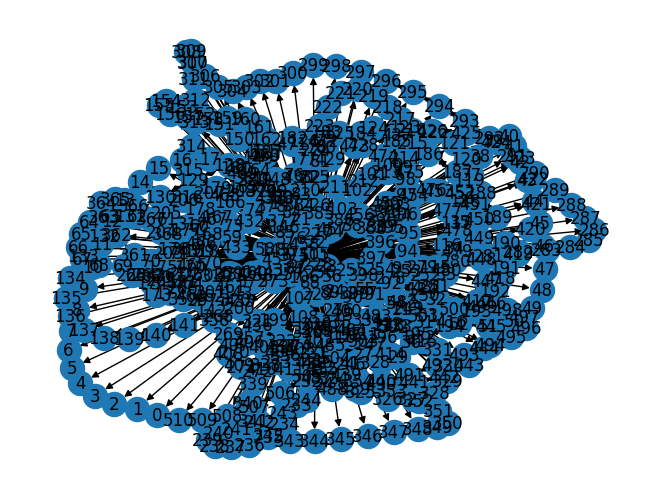

<Figure size 5000x5000 with 0 Axes>

In [164]:
# Number of nodes
N = 512

def create_graph(N):
    # Note that final center node is of idx N-1
    G = nx.MultiDiGraph()
    
    # Add N nodes
    nodes = range(0, N-1)
    G.add_nodes_from(nodes)
    
    # Add bidirectional connections for the first N-1 nodes
    for i in range(0, N-2):
        G.add_edge(i, i+1)
        G.add_edge(i+1, i)
    
    # Add connections between idx N-2 and 0

    G.add_edge(N-2, 0)
    G.add_edge(0, N-2)

    # Add unidirectional connections for the last node
    for i in range(0, N-1):
        G.add_edge(N-1, i)
    
    return G

G = create_graph(N)

edge_feat = get_edge_features(N)
for idx, (u, v, e) in enumerate(G.edges(data=True)):
    e['feature'] = edge_feat[idx]

image_encoding = torch.rand(1, 768)
node_feat = get_node_features(N, image_encoding, 2, odometry=None)

# Set the node and edge features in the graph object
for i, feat in enumerate(node_feat):
    G.nodes[i]['feature'] = feat

# Draw the graph
pos = nx.circular_layout(G)
nx.draw(G, with_labels=True)

plt.figure(figsize=(50,50))
plt.show()

In [ ]:
G.edges(data=True)

In [142]:
G.nodes(data=True)

NodeDataView({0: {'feature': tensor([0.5147, 2.0000, 1.0000, 0.0000], dtype=torch.float64)}, 1: {'feature': tensor([0.5147, 2.0000, 0.3090, 0.9511], dtype=torch.float64)}, 2: {'feature': tensor([ 0.5147,  2.0000, -0.8090,  0.5878], dtype=torch.float64)}, 3: {'feature': tensor([ 0.5147,  2.0000, -0.8090, -0.5878], dtype=torch.float64)}, 4: {'feature': tensor([ 0.5147,  2.0000,  0.3090, -0.9511], dtype=torch.float64)}, 5: {'feature': tensor([0.5147, 5.0000, 0.0000, 0.0000], dtype=torch.float64)}})

In [163]:
# create edge index from 
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

In [153]:
edge_index

tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5],
        [1, 4, 0, 2, 1, 3, 2, 4, 0, 3, 0, 1, 2, 3, 4]])

In [171]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        # add 5 fully connected layers to gradually reduce the dimension
        self.fc1 = torch.nn.Linear(out_channels, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 8)
        self.fc5 = torch.nn.Linear(8, 4)

    def forward(self, x, edge_index):
        # Apply the first GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Apply the second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Global pooling to obtain the graph embedding
        x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))

        # add fully connected layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Instantiate the GCN model
model = GCN(num_features=node_feat.shape[1], hidden_channels=16, out_channels=N)
model.to(device)

# Generate the input features and edge index tensor for the model
x = torch.tensor(node_feat, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Compute the graph embedding using the GCN model
embedding = model(x, edge_index)

<ipython-input-171-a33943a88b8d>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(node_feat, dtype=torch.float)
<ipython-input-171-a33943a88b8d>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)
